# CF based recommender system using neural networks
## Books for mystery, thriller, and crime
https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home

In [1]:
import sys
sys.path.append('/home/014521052/venv-3.6.6-gpu/lib/python3.6/site-packages')

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

### Load Data

In [2]:
user_id_df = pd.read_csv('user_id_map.csv')
print(user_id_df.shape)
user_id_df.head(3)

(876145, 2)


,user_id_csv,user_id
0,0,8842281e1d1347389f2ab93d60773d4d
1,1,72fb0d0087d28c832f15776b0d936598
2,2,ab2923b738ea3082f5f3efcbbfacb218


In [3]:
book_id_df = pd.read_csv('book_id_map.csv')
print(book_id_df.shape)
book_id_df.head(3)

(2360650, 2)


,book_id_csv,book_id
0,0,34684622
1,1,34536488
2,2,34017076


In [4]:
train_df = pd.read_csv('data/train.csv')
print(train_df.shape)
train_df.head(3)

(9876021, 3)


,user_id,book_id,rating
0,eabd6e8c6dc181d8fb5bd65573e9b51b,25365,3
1,f6bf54164ddeba9eb812c024aff1902c,8467921,3
2,7322c5cb2d2dc8a289374e8ae5c4903a,29960804,2


In [5]:
test_df = pd.read_csv('data/test.csv')
print(test_df.shape)
test_df.head(3)

(2549129, 3)


,user_id,book_id,rating
0,4374ea549de7ab51ce7ef59311babfee,17185496,4
1,f2fd8750f9b4b167e2eea57def6b0657,5349974,0
2,0e836dfd49f285f2e564145cd7ab245e,105992,5


### Data merge with user_id and book_id map

In [6]:
temp = pd.merge(train_df[['user_id', 'book_id', 'rating']], user_id_df[['user_id','user_id_csv']], on='user_id' )
trainSet = pd.merge(temp[['user_id', 'book_id', 'rating', 'user_id_csv']], book_id_df[['book_id','book_id_csv']], on='book_id' )
print(trainSet.shape)
trainSet.sample(3)

(9876021, 5)


,user_id,book_id,rating,user_id_csv,book_id_csv
3653502,d4620877b85d883c77d4d2e0af488c8f,6854,4,74379,42703
4682740,2d2b2be03791bb8b0123a0c7d80e53b3,85321,5,70576,27954
5018032,a2d53c1c4d46ba947380a81d63a4d760,13518651,3,36197,213872


In [7]:
temp = pd.merge(test_df[['user_id', 'book_id', 'rating']], user_id_df[['user_id','user_id_csv']], on='user_id' )
testSet = pd.merge(temp[['user_id', 'book_id', 'rating', 'user_id_csv']], book_id_df[['book_id','book_id_csv']], on='book_id' )
print(testSet.shape)
testSet.sample(3)

(2549129, 5)


,user_id,book_id,rating,user_id_csv,book_id_csv
2066666,491bed2878d77b63d5c70403eb1f86ff,23312692,5,593165,10140
1991895,aac9e85f2ebeb84578c6d9457bcbf7aa,7941693,4,320881,562905
1987790,a824ee0836b073758f2e6397ab5ab408,28146828,4,2595,359194


### Data Exploration

In [8]:
train_df.describe()

,book_id,rating
count,9.876021e+06,9.876021e+06
mean,8.298135e+06,3.605505e+00
std,9.922950e+06,1.311846e+00
min,1.640000e+02,0.000000e+00
25%,9.829300e+04,3.000000e+00
50%,2.429135e+06,4.000000e+00
75%,1.608548e+07,5.000000e+00
max,3.649449e+07,5.000000e+00


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9876021 entries, 0 to 9876020
Data columns (total 3 columns):
user_id    object
book_id    int64
rating     int64
dtypes: int64(2), object(1)
memory usage: 226.0+ MB


In [10]:
train_df.isnull().sum(axis=0)

user_id    0
book_id    0
rating     0
dtype: int64

In [11]:
num_users = train_df.book_id.nunique()
num_books = train_df.user_id.nunique()

print("Number of users: ", num_users)
print("Number of books: ", num_books)

Number of users:  211013
Number of books:  497178


rating=0, n=627848 (6.357%)
rating=1, n=153336 (1.553%)
rating=2, n=549580 (5.565%)
rating=3, n=2367284 (23.970%)
rating=4, n=3636165 (36.818%)
rating=5, n=2541808 (25.737%)


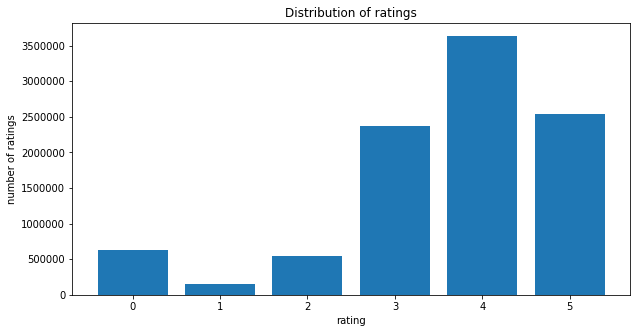

In [12]:
from collections import Counter

counter = Counter(sorted(train_df.rating))

for k,v in counter.items():
    per = v/len(train_df.rating)*100
    print('rating=%d, n=%d (%.3f%%)'%(k, v, per))

#plot class distribution
plt.figure(figsize=(10, 5))
plt.title('Distribution of ratings')
plt.bar(counter.keys(), counter.values())
plt.xlabel('rating')
plt.ylabel('number of ratings')
plt.show()

In [13]:
# split dataset into train and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(trainSet, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((7900816, 5), (1975205, 5))

### Model Creation

In [14]:
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)

Tensorflow Version:  1.14.0
Keras Version:  2.2.4-tf


In [15]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Concatenate
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dot
from tensorflow.keras.layers import dot

In [16]:
#https://medium.com/@victorkohler/collaborative-filtering-using-deep-neural-networks-in-tensorflow-96e5d41a39a1

def gen_NN_model(n_factors, lr):
    #user input network
    input_users = Input(shape=[1])
    embed_users = Embedding(num_users + 1, 
                            n_factors,
                            embeddings_initializer='glorot_uniform',
                            embeddings_regularizer=l2(0.0001))(input_users)
    users_out = Flatten()(embed_users)
    
    #book input network
    input_books = Input(shape=[1])
    embed_books = Embedding(num_books + 1, 
                            n_factors,
                            embeddings_initializer='glorot_uniform',
                            embeddings_regularizer=l2(0.0001))(input_books)
    books_out = Flatten()(embed_books)

    conc_layer = Concatenate()([users_out, books_out])
    x = Dropout(0.2)(conc_layer)
    
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x) 
    x = Dropout(0.2)(x) 
    
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x) 
    x = Dropout(0.2)(x) 
    
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    #x = Dropout(0.5)(x) 
    #x = BatchNormalization()(x) 
    x_out = x = Dense(1, activation='relu')(x)
    model = Model([input_users, input_books], x_out)
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mean_squared_error',
        metrics = [tf.keras.metrics.RootMeanSquaredError(name='RMSE')]
    )
      
    return model

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=10,
    mode='auto',
    restore_best_weights=True
    )

### Model Training and Validation

In [18]:
#set parameters
EmbedSize = 32 
Op_lr = 0.001 

In [19]:
#model = gen_NN_model(n_factors=EmbedSize, lr=Op_lr)
#model.summary()

model = tf.keras.models.load_model('tf_NN_model(n_epoch3).h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
n_iter = 25

for i in range(4, n_iter):
    history = model.fit(
        [X_train.user_id_csv, X_train.book_id_csv], X_train.rating,
        batch_size=512,
        epochs=1,
        validation_data=([X_test.user_id_csv, X_test.book_id_csv], X_test.rating)
    ) 
    
    model_name = 'tf_NN_model(n_epoch%s)'%(i) + '.h5'
    print(model_name)
    model.save(model_name)

Train on 7900816 samples, validate on 1975205 samples
2240512/7900816 [=======>......................] - ETA: 15:05 - loss: 1.6747 - RMSE: 1.2463

### Model Evaluation using test dataset

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.ylim([min(plt.ylim()), 2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#new_model = tf.keras.models.load_model('my_model.h5')